In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/BA820 Project/Dataset/merged_data_small.parquet')
print(df.head())

                 user_id                 name_x           time  rating  \
0  116404531305033742641  Zygintas Krasodomskis  1568240961087     5.0   
1  101806853201406057266            Olga Harbar  1590701094969     3.0   
2  110623621391484838669             Amit Patel  1558575636156     4.0   
3  114893265310260912873         Jerry Cardillo  1535435901765     4.0   
4  106080008682473967828           Jake Moreira  1487952273508     4.0   

                                                text  resp  \
0                     Honestly, best burgers in town  None   
1                                               None  None   
2                                               None  None   
3                                               None  None   
4  This place gave me a good sanwich and a fry bu...  None   

                                 gmap_id                 name_y  \
0  0x89e37a19e56a4565:0xbb2aefc495e8c505              Five Guys   
1  0x89e45acc1861f709:0x9ccc502a907ff195  Price 

In [3]:
df.isnull().sum()

,0
user_id,0
name_x,0
time,0
rating,0
text,391626
resp,756452
gmap_id,0
name_y,0
address,0
latitude,0


In [4]:
df['text'] = df['text'].fillna("N/A")
df['resp'] = df['resp'].fillna("N/A")

In [5]:
df.isnull().sum()

,0
user_id,0
name_x,0
time,0
rating,0
text,0
resp,0
gmap_id,0
name_y,0
address,0
latitude,0


In [6]:
numerical_cols = ['rating', 'latitude', 'longitude', 'avg_rating', 'num_of_reviews']
categorical_cols = ['category']
text_cols = ['text', 'resp']

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[numerical_cols])

num_df = pd.DataFrame(num_scaled, columns=[f"num_feature_{i}" for i in range(num_scaled.shape[1])])

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
category_encoded = mlb.fit_transform(df[categorical_cols])

category_df = pd.DataFrame(category_encoded, columns=mlb.classes_)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer_text = TfidfVectorizer(stop_words='english', max_features=50)
vectorizer_resp = TfidfVectorizer(stop_words='english', max_features=50)

text_transformed = vectorizer_text.fit_transform(df['text'])
resp_transformed = vectorizer_resp.fit_transform(df['resp'])

# Convert to DataFrame
text_df = pd.DataFrame(text_transformed.toarray(), columns=[f"text_{col}" for col in vectorizer_text.get_feature_names_out()])
resp_df = pd.DataFrame(resp_transformed.toarray(), columns=[f"resp_{col}" for col in vectorizer_resp.get_feature_names_out()])

In [10]:
from sklearn.ensemble import IsolationForest
import numpy as np

important_features_scaled = ['num_feature_0', 'num_feature_3', 'num_feature_4']  # scaled rating, avg_rating, and num_of_reviews

final_df_optimized = pd.concat([num_df[important_features_scaled], text_df, resp_df], axis=1)

iso_forest_optimized = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_score'] = iso_forest_optimized.fit_predict(final_df_optimized)

df['anomaly'] = np.where(df['anomaly_score'] == -1, "Suspicious", "Normal")


In [11]:
df[['name_y', 'rating', 'avg_rating', 'num_of_reviews', 'anomaly']].head(20)


,name_y,rating,avg_rating,num_of_reviews,anomaly
0,Five Guys,5.0,4.3,842.0,Normal
1,Price Rite of Seekonk,3.0,4.3,895.0,Normal
2,Coreanos Allston,4.0,4.6,446.0,Normal
3,Pied Bar,4.0,3.9,38.0,Normal
4,Chick-fil-A,4.0,4.5,2543.0,Normal
5,Naismith Memorial Basketball Hall of Fame,4.0,4.4,2426.0,Normal
6,Capri Pizza,4.0,4.5,508.0,Normal
7,Hall Memorial Pool,1.0,4.3,68.0,Normal
8,Mann Orchards,5.0,4.6,768.0,Normal
9,McDonald's,2.0,3.6,357.0,Normal


In [12]:
suspicious_businesses = df[df['anomaly'] == "Suspicious"]
suspicious_businesses.head(3)


,user_id,name_x,time,rating,text,resp,gmap_id,name_y,address,latitude,longitude,category,avg_rating,num_of_reviews,hours,MISC,relative_results,url,anomaly_score,anomaly
10,108516292984194833708,Kelly Moniz,1584363629874,4.0,Excellent service,"{'time': 1584546750598, 'text': 'Thank you for...",0x89e4e4a771a2b5a1:0xaa0a81cc4243f4c4,99 Restaurants,"99 Restaurants, 161 Faunce Corner Rd, North Da...",41.652719,-70.986844,"['Restaurant', 'Bar', 'Bar & grill', 'New Engl...",4.3,926.0,"[['Tuesday', '11AM–9:30PM'], ['Wednesday', '11...","{'Service options': ['Curbside pickup', 'Deliv...","['0x89e4fcb3a3480ad7:0xba5a90641f3a907f', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,-1,Suspicious
28,110778088802047490447,Cat D,1565296494452,5.0,Great place and the staff is awesome!!!,"{'time': 1565369782931, 'text': ""Hi there! Tha...",0x89e314af2e05250b:0x3f1464664138d7c2,Palm Beach Tan,"Palm Beach Tan, 1016 Paradise Rd, Swampscott, ...",42.484879,-70.900912,['Tanning salon'],4.0,17.0,"[['Tuesday', '11AM–8PM'], ['Wednesday', '11AM–...","{'Amenities': ['Gender-neutral restroom'], 'Pa...","['0x89e314a8ab1187a3:0x17ab58fa11d682cc', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,-1,Suspicious
42,112402711741657491733,Ritch Sternbach,1533768748481,4.0,This place is a great no pressure Dealership t...,"{'time': 1533909497052, 'text': ""Ritch, we str...",0x89e47fd0b70d5181:0xb8bf0242f46c5ea3,Clay Subaru,"Clay Subaru, 842 Providence Hwy Rte 1, Norwood...",42.183200,-71.186667,"['Subaru dealer', 'Auto broker', 'Auto repair ...",4.2,458.0,"[['Tuesday', '9AM–8PM'], ['Wednesday', '9AM–8P...","{'Service options': ['In-store shopping'], 'Ac...","['0x89e36317f466637b:0x218e94e29cd5f864', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,-1,Suspicious


In [13]:
print(df['anomaly'].value_counts())


anomaly
Normal        818417
Suspicious     43075
Name: count, dtype: int64


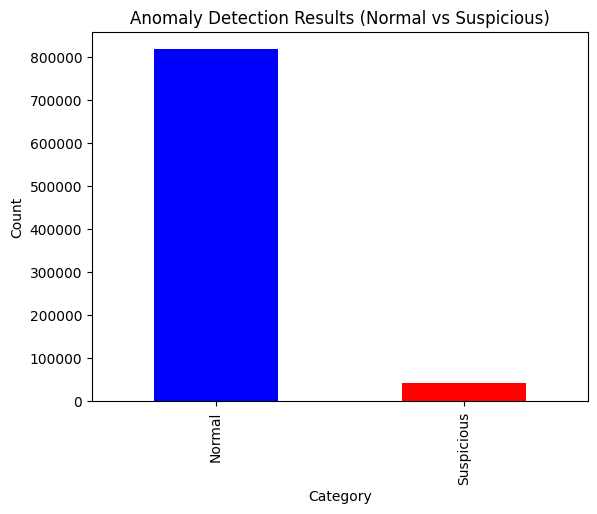

In [14]:
import matplotlib.pyplot as plt

df['anomaly'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Anomaly Detection Results (Normal vs Suspicious)")
plt.show()


Chart with full dataset.

In [15]:
#30% of data
df_sample = df.sample(frac=0.3, random_state=42)

text_df_reduced = text_df.iloc[:, :20]
resp_df_reduced = resp_df.iloc[:, :20]

final_df_optimized = pd.concat([num_df.loc[df_sample.index, important_features_scaled],
                                text_df_reduced.loc[df_sample.index],
                                resp_df_reduced.loc[df_sample.index]], axis=1)

iso_forest_optimized = IsolationForest(
    n_estimators=100,
    contamination=0.03,
    max_samples=5000,
    random_state=42,
    verbose=1
)
df_sample['anomaly_score'] = iso_forest_optimized.fit_predict(final_df_optimized)
df_sample['anomaly'] = np.where(df_sample['anomaly_score'] == -1, "Suspicious", "Normal")




[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


I did manual tuning before with whole dataset and my colab crashed, so I took a sample of the dataset here.

In [16]:
df_sample[['name_y', 'rating', 'avg_rating', 'num_of_reviews', 'anomaly']].head(20)


,name_y,rating,avg_rating,num_of_reviews,anomaly
76173,Arax Market,5.0,4.5,488.0,Normal
186462,Arturo's Ristorante,5.0,4.5,812.0,Normal
386586,Michaels,5.0,4.4,778.0,Normal
292577,The Spirit Shoppe,4.0,4.2,38.0,Normal
346640,Tint Works,5.0,4.8,148.0,Normal
699243,Domino's Pizza,5.0,4.0,107.0,Normal
254573,H&M,4.0,4.2,835.0,Normal
360022,Starbucks,3.0,4.1,158.0,Normal
732615,Market Basket,1.0,4.5,598.0,Normal
570070,Tavern in the Square,5.0,4.2,1438.0,Normal


In [17]:
suspicious_businesses = df_sample[df_sample['anomaly'] == "Suspicious"]
suspicious_businesses.head(3)


,user_id,name_x,time,rating,text,resp,gmap_id,name_y,address,latitude,longitude,category,avg_rating,num_of_reviews,hours,MISC,relative_results,url,anomaly_score,anomaly
788995,106735362825975862464,Julia Zechello,1542842238720,5.0,Lola and Zach were the absolute best! Cannot w...,"{'time': 1542986669675, 'text': ""Thank you for...",0x8842448b81c9f937:0x59ddac578c16502b,Breakout Games - Boston (Marlborough),"Breakout Games - Boston (Marlborough), 21 Apex...",42.338197,-71.584863,['Escape room center'],4.9,2137.0,"[['Sunday', '10AM–11:30PM'], ['Monday', '10AM–...",{'Accessibility': ['Wheelchair accessible entr...,"['0x89e40667948f37a7:0xaecf73eb02095a97', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,-1,Suspicious
29500,113758310803575954371,Matt Guillemette,1578274257837,5.0,Salesmen knew when to let me roam the floor an...,"{'time': 1578336165057, 'text': 'Hi Matt! We a...",0x89e6e0cf8be4ac87:0x839ad6d19e932c5b,Raymour & Flanigan Furniture and Mattress Outlet,Raymour & Flanigan Furniture and Mattress Outl...,42.122642,-72.626771,"['Furniture store', 'Bedroom furniture store',...",4.6,728.0,"[['Sunday', '11AM–6PM'], ['Monday', '10AM–9PM'...","{'Service options': ['Delivery', 'In-store pic...","['0x89e6e6c49299469b:0x7ba48fd6ea67f1e4', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,-1,Suspicious
437830,106999754264130128141,Laurie M,1570734035592,5.0,N/A,"{'time': 1571084085245, 'text': ""Laurie, we're...",0x89e6c2ac05f28a49:0x96616024102f5c2d,Thrifty Car Sales - Springfield,"Thrifty Car Sales - Springfield, 880 Boston Rd...",42.137854,-72.515219,['Used car dealer'],4.3,224.0,"[['Thursday', '9AM–8PM'], ['Friday', '9AM–6PM'...","{'Service options': ['In-store shopping'], 'Ac...","['0x89e6e7ee71de013b:0xe0010d4db9e21d86', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,-1,Suspicious


In [18]:
df_sample['anomaly'].value_counts()


,count
anomaly,
Normal,250694
Suspicious,7754


In [19]:
feature_importance = pd.DataFrame({
    'Feature': final_df_optimized.columns,
    'Importance': iso_forest_optimized.decision_function(final_df_optimized).var(axis=0)
}).sort_values(by='Importance', ascending=False)

print(feature_importance.head(10))


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s


            Feature  Importance
0     num_feature_0    0.000962
32  resp_experience    0.000962
24        resp_best    0.000962
25    resp_business    0.000962
26         resp_com    0.000962
27        resp_come    0.000962
28     resp_contact    0.000962
29    resp_customer    0.000962
30   resp_customers    0.000962
31     resp_enjoyed    0.000962


In [20]:
df_analysis = df_sample[['name_y', 'anomaly']].merge(final_df_optimized, left_index=True, right_index=True)

df_analysis[df_analysis['anomaly'] == "Suspicious"][['name_y', 'anomaly'] + list(feature_importance['Feature'].head(10))]


,name_y,anomaly,num_feature_0,resp_experience,resp_best,resp_business,resp_com,resp_come,resp_contact,resp_customer,resp_customers,resp_enjoyed
788995,Breakout Games - Boston (Marlborough),Suspicious,0.607172,0.344794,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.441619
29500,Raymour & Flanigan Furniture and Mattress Outlet,Suspicious,0.607172,0.321704,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
437830,Thrifty Car Sales - Springfield,Suspicious,0.607172,0.000000,0.000000,0.000000,0.000000,0.0,0.571269,0.0,0.000000,0.000000
394735,Lawless CDJR,Suspicious,0.607172,0.355660,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
560784,Bourne's Auto Center,Suspicious,0.607172,0.000000,0.000000,0.342698,0.000000,0.0,0.375802,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
253109,Kings Dining & Entertainment,Suspicious,-2.016535,0.000000,0.000000,0.369924,0.362734,0.0,0.000000,0.0,0.000000,0.000000
379874,Monro Auto Service And Tire Centers,Suspicious,0.607172,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
527953,99 Restaurants,Suspicious,0.607172,0.228825,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
107822,Stop & Shop,Suspicious,0.607172,0.235696,0.296817,0.000000,0.000000,0.0,0.000000,0.0,0.315812,0.000000


Shows how much the features took part to see how it turned into Suspicious

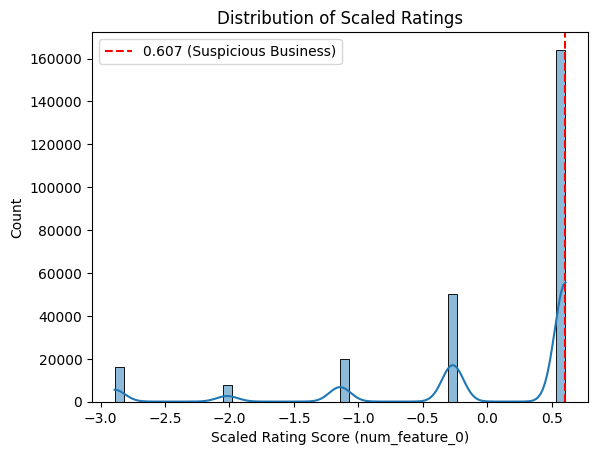

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


df_sample = df_sample.merge(num_df[['num_feature_0']], left_index=True, right_index=True)

sns.histplot(df_sample['num_feature_0'], bins=50, kde=True)
plt.axvline(0.607, color='red', linestyle='dashed', label="0.607 (Suspicious Business)")
plt.xlabel("Scaled Rating Score (num_feature_0)")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Scaled Ratings")
plt.show()

This histogram shows the distribution of scaled ratings (num_feature_0) across all businesses in your dataset.

In [22]:
df_sample.groupby('anomaly')['num_feature_0'].describe()


,count,mean,std,min,25%,50%,75%,max
anomaly,,,,,,,,
Normal,250694.0,0.015280,0.980336,-2.891104,-0.267397,0.607172,0.607172,0.607172
Suspicious,7754.0,-0.387631,1.411447,-2.891104,-1.141966,0.607172,0.607172,0.607172


## Hyperparameter optimization

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import make_scorer

param_dist = {
    "n_estimators": randint(50, 300),
    "max_samples": randint(1000, 10000),
    "contamination": [0.01, 0.02, 0.03, 0.05, 0.1],  # Anomaly proportions
}

def isolation_forest_score(estimator, X):
    return estimator.decision_function(X).mean()

iso_forest = IsolationForest(random_state=42)

#Hyperparameter tuning
random_search = RandomizedSearchCV(
    iso_forest, param_distributions=param_dist,
    n_iter=10, cv=3, verbose=1, n_jobs=-1,
    scoring=make_scorer(isolation_forest_score, greater_is_better=True),
    random_state=42
)

random_search.fit(final_df_optimized)
best_params = random_search.best_params_
print("Best Parameters:", best_params)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'contamination': 0.05, 'max_samples': 1860, 'n_estimators': 64}


Best parameters from RandomizedSearchCV are:

contamination=0.05 → Higher contamination than our initial 0.03, meaning more businesses are flagged as anomalies.

max_samples=1860 → Much lower than our manually chosen 5000, suggesting that a smaller sample size works better for this dataset.

n_estimators=64 → Lower than our initial 100, meaning fewer trees were sufficient for optimal performance in this tuning run, balancing detection accuracy and computation time.

# Train the Isolation Forest model using the best parameters from RandomizedSearchCV

Train the Optimized Model

In [24]:
best_iso_forest = IsolationForest(
    contamination=0.05,
    max_samples=1860,
    n_estimators=64,
    random_state=42
).fit(final_df_optimized)


Apply the Model & View Anomaly Counts

In [25]:
df_sample['anomaly_optimized'] = best_iso_forest.fit_predict(final_df_optimized)
df_sample['anomaly_optimized'] = np.where(df_sample['anomaly_optimized'] == -1, "Suspicious", "Normal")
print(df_sample['anomaly_optimized'].value_counts())


anomaly_optimized
Normal        245525
Suspicious     12923
Name: count, dtype: int64


Compare Old vs. New Anomaly Results

In [26]:
df_sample['anomaly_comparison'] = df_sample['anomaly'] + " → " + df_sample['anomaly_optimized']
print(df_sample['anomaly_comparison'].value_counts())


anomaly_comparison
Normal → Normal            245429
Suspicious → Suspicious      7658
Normal → Suspicious          5265
Suspicious → Normal            96
Name: count, dtype: int64


View Top Suspicious Businesses

In [27]:
suspicious_businesses_optimized = df_sample[df_sample['anomaly_optimized'] == "Suspicious"]
print(suspicious_businesses_optimized[['name_y', 'anomaly_optimized']].head(10))


                                                  name_y anomaly_optimized
14543                              Acorn Animal Hospital        Suspicious
806962                                   Dave & Buster's        Suspicious
788995             Breakout Games - Boston (Marlborough)        Suspicious
29500   Raymour & Flanigan Furniture and Mattress Outlet        Suspicious
437830                   Thrifty Car Sales - Springfield        Suspicious
394735                                      Lawless CDJR        Suspicious
560784                              Bourne's Auto Center        Suspicious
619143                                        Dr. Dental        Suspicious
353970                               Extra Space Storage        Suspicious
734080                             Foundry Street Garage        Suspicious


In [28]:
print(feature_importance.head(10))


            Feature  Importance
0     num_feature_0    0.000962
32  resp_experience    0.000962
24        resp_best    0.000962
25    resp_business    0.000962
26         resp_com    0.000962
27        resp_come    0.000962
28     resp_contact    0.000962
29    resp_customer    0.000962
30   resp_customers    0.000962
31     resp_enjoyed    0.000962


##Text Analysis

In [29]:
import scipy
import scipy.sparse
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Sample 20%
df_sampled = df_sample.sample(frac=0.2, random_state=42)

text_tfidf_sparse_sampled = scipy.sparse.csr_matrix(text_df.loc[df_sampled.index])

nbrs = NearestNeighbors(n_neighbors=5, metric='cosine', algorithm='auto', n_jobs=-1).fit(text_tfidf_sparse_sampled)

distances, indices = nbrs.kneighbors(text_tfidf_sparse_sampled)

similarity_scores = 1 - distances

df_sample.loc[df_sampled.index, 'text_similarity_score'] = np.sum(similarity_scores > 0.9, axis=1)


had to use sample because the session was crashing

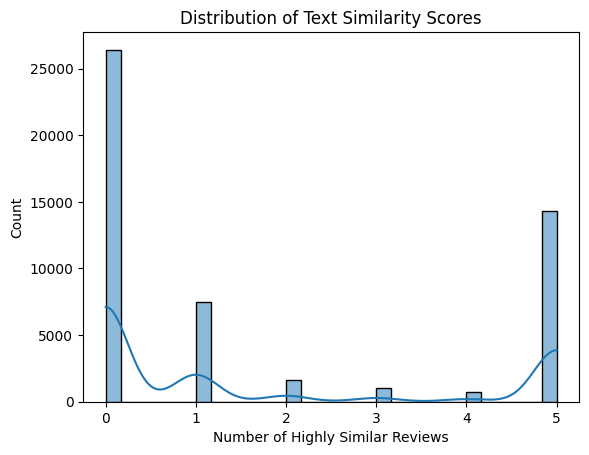

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_sample['text_similarity_score'].dropna(), bins=30, kde=True)
plt.xlabel("Number of Highly Similar Reviews")
plt.ylabel("Count")
plt.title("Distribution of Text Similarity Scores")
plt.show()


In [31]:
suspicious_threshold = 3
suspicious_businesses = df_sample[df_sample['text_similarity_score'] >= suspicious_threshold][['name_y', 'text_similarity_score']]

# Top 10 suspicious businesses
print(suspicious_businesses.sort_values(by="text_similarity_score", ascending=False).head(10))


                                        name_y  text_similarity_score
346640                              Tint Works                    5.0
391125  The Original Tommy Doyle's Pub & Grill                    5.0
618170                           Sher-A-Punjab                    5.0
629402                         Pit Stop Tavern                    5.0
349703                                  B.GOOD                    5.0
435752                       Nathan Tufts Park                    5.0
229785                  Gourmet Dumpling House                    5.0
763239                         Burlington Mall                    5.0
22119                     Tiki Port Restaurant                    5.0
659086                               Taco Bell                    5.0


In [32]:
df_comparison = df_sample[['name_y', 'anomaly', 'anomaly_optimized', 'text_similarity_score']]
df_comparison = df_comparison.sort_values(by="text_similarity_score", ascending=False)

df_comparison.head(10)


,name_y,anomaly,anomaly_optimized,text_similarity_score
346640,Tint Works,Normal,Normal,5.0
357884,Skampa,Normal,Normal,5.0
468017,AutoZone Auto Parts,Normal,Normal,5.0
26658,Cabela's,Normal,Normal,5.0
842132,Best Buy,Normal,Normal,5.0
575764,Sentry West Mazda,Normal,Suspicious,5.0
424303,Empire,Normal,Normal,5.0
762233,John's Corner,Normal,Normal,5.0
467753,ALDI,Normal,Normal,5.0
623568,Kowloon Restaurant,Normal,Normal,5.0


In [46]:
final_df_optimized['text_similarity_score'] = df_sample['text_similarity_score']

iso_forest_updated = IsolationForest(
    contamination=0.05,
    random_state=42
).fit(final_df_optimized)

df_sample['anomaly_updated'] = iso_forest_updated.fit_predict(final_df_optimized)
df_sample['anomaly_updated'] = np.where(df_sample['anomaly_updated'] == -1, "Suspicious", "Normal")

print(df_sample['anomaly_updated'].value_counts())


anomaly_updated
Normal        245525
Suspicious     12923
Name: count, dtype: int64


In [47]:
df_sample['anomaly_comparison_updated'] = df_sample['anomaly'] + " → " + df_sample['anomaly_updated']
print(df_sample['anomaly_comparison_updated'].value_counts())


anomaly_comparison_updated
Normal → Normal            245013
Suspicious → Suspicious      7242
Normal → Suspicious          5681
Suspicious → Normal           512
Name: count, dtype: int64


In [48]:
new_suspicious = df_sample[(df_sample['anomaly'] == "Normal") & (df_sample['anomaly_updated'] == "Suspicious")]
print(new_suspicious[['name_y', 'text_similarity_score']].sort_values(by="text_similarity_score", ascending=False).head(10))


                                name_y  text_similarity_score
385640                    Balise Lexus                    5.0
563306               Prudential Center                    5.0
635284           Keldara Salon and Spa                    5.0
687038        Big Y World Class Market                    5.0
521281     Maqui's Bar & Function Hall                    5.0
270771                     Chick-fil-A                    5.0
761814        Faneuil Hall Marketplace                    5.0
89807                    China Blossom                    5.0
518511  Ray's Vehicle State Inspection                    5.0
265335        The Industry Bar & Grill                    5.0


In [49]:
suspicious_texts = df_sample[df_sample['anomaly_updated'] == "Suspicious"]

suspicious_texts = suspicious_texts[['name_y', 'text', 'resp', 'text_similarity_score']]

suspicious_texts = suspicious_texts.sort_values(by="text_similarity_score", ascending=False)

suspicious_texts.head(10)

,name_y,text,resp,text_similarity_score
540833,Hook & Reel Cajun Seafood and Bar,Food served in a plastic bag?,"{'time': 1582229931146, 'text': 'Hi Geoff, tha...",5.0
2212,AT&T Store,The guy at our local AT&T (Nate) was extremely...,"{'time': 1617654503187, 'text': 'Hello Amorife...",5.0
767744,Tony C's Sports Bar and Grill,Ordered chicken sandwich to go. They gave me a...,"{'time': 1536777062004, 'text': 'Good Afternoo...",5.0
27873,Millennium Pizza,Absolutely the best buffalo chicken pizza and ...,"{'time': 1569378368310, 'text': 'Thank you for...",5.0
620882,AT&T Store,Terrible not good customer service,"{'time': 1568652271624, 'text': ""Hi Velmalee! ...",5.0
833841,"Haverhill Prime Dental - Haverhill, MA",First visit today. The staff was super friendl...,"{'time': 1552066223086, 'text': 'Hi Khristine\...",5.0
221524,99 Restaurants,Order was wrong...food barely lukewarm...,"{'time': 1575903700358, 'text': ""We're so sorr...",5.0
739236,The Time Capsule,Very knowledgeable and friendly staff. Great s...,"{'time': 1583107706046, 'text': ""Thanks Craig!...",5.0
362170,Safelite AutoGlass,Left a pile of glass in my driveway before I n...,"{'time': 1611156793092, 'text': ""We're sorry t...",5.0
687144,PLS Check Cashing Store,"Jeidy, best costumer services ever\n, best cos...","{'time': 1612706961350, 'text': 'Mario Suazo, ...",5.0


In [50]:
iso_forest_test = IsolationForest(
    contamination=0.07,
    random_state=42
).fit(final_df_optimized)

df_sample['anomaly_test'] = iso_forest_test.fit_predict(final_df_optimized)
df_sample['anomaly_test'] = np.where(df_sample['anomaly_test'] == -1, "Suspicious", "Normal")

print(df_sample['anomaly_test'].value_counts())


anomaly_test
Normal        240356
Suspicious     18092
Name: count, dtype: int64


In [51]:
df_sample[df_sample['anomaly_test'] == "Suspicious"]['rating'].describe()


,rating
count,18092.000000
mean,4.045821
std,1.506293
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [53]:
df_consistent_suspicious = df_sample[
    (df_sample['anomaly'] == "Suspicious") &
    (df_sample['anomaly_updated'] == "Suspicious") &
    (df_sample['anomaly_test'] == "Suspicious")
]
df_consistent_suspicious[['name_y', 'text_similarity_score']].head(10)


,name_y,text_similarity_score
788995,Breakout Games - Boston (Marlborough),NaN
29500,Raymour & Flanigan Furniture and Mattress Outlet,3.0
394735,Lawless CDJR,NaN
619143,Dr. Dental,1.0
734080,Foundry Street Garage,NaN
374653,Penske Truck Rental,NaN
484862,Verizon Authorized Retailer - Russell Cellular,NaN
52798,Stockholders,NaN
632836,Clover Food Lab,5.0
504221,Lyndon Tree Care & Landscaping,1.0


In [57]:
df_location = df_sample[df_sample['anomaly_updated'] == "Suspicious"][['longitude', 'latitude']]

##Map of Suspicious businesses

In [58]:
df_location.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12923 entries, 806962 to 176717
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  12923 non-null  float64
 1   latitude   12923 non-null  float64
dtypes: float64(2)
memory usage: 302.9 KB


In [59]:
import numpy as np
from pyproj import Transformer
from sklearn.cluster import DBSCAN

transformer = Transformer.from_crs("EPSG:4326", "EPSG:32619", always_xy=True)
x_coords, y_coords = transformer.transform(
    df_location['longitude'].values,  # longitude
    df_location['latitude'].values   # latitude
)

coords_m = np.column_stack((x_coords, y_coords))

dbscan = DBSCAN(eps=10000, min_samples=50, metric='euclidean').fit(coords_m)
df_location['cluster'] = dbscan.labels_

In [60]:
df_location['cluster'].value_counts()

,count
cluster,
0,10955
1,1190
2,420
3,161
-1,138
4,59


In [61]:
from sklearn.metrics import silhouette_score
import numpy as np

# Filter out noise points
mask = df_location['cluster'] != -1
if len(np.unique(df_location.loc[mask, 'cluster'])) > 1:
    score = silhouette_score(coords_m[mask], df_location.loc[mask, 'cluster'])
    print("Silhouette Score:", score)
else:
    print("Not enough clusters for silhouette score calculation.")


Silhouette Score: 0.5231067871807547


In [62]:
!pip install cartopy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 67.3 MB/s eta 0:00:00


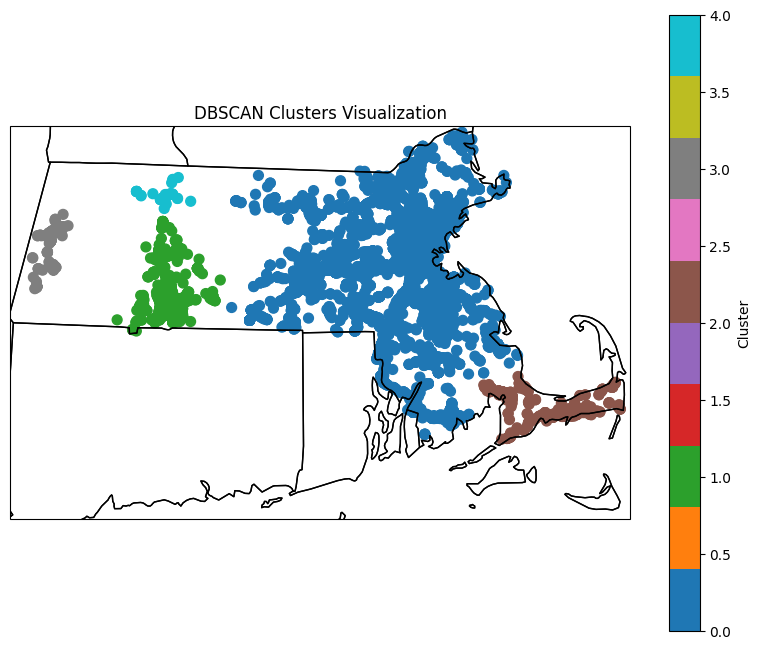

In [65]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

df_filtered = df_location[df_location['cluster'] != -1].copy()
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([-73.5, -69.9, 41.2, 42.9], crs=ccrs.PlateCarree())

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='black')

scatter = ax.scatter(
    df_filtered['longitude'],
    df_filtered['latitude'],
    c=df_filtered['cluster'],
    cmap='tab10',
    s=50,
    transform=ccrs.PlateCarree()
)

plt.colorbar(scatter, ax=ax, label='Cluster')
plt.title('DBSCAN Clusters Visualization')
plt.show()


Clusters of only the suspicious businesses